# 3. Timeseries Classification from Scratch (2-3-23)

Learned simple things about timeseries data; learned about model.fit callbacks, learned about
Conv1D and BatchNormalization

In [1]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

2023-02-03 15:14:12.360937: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    #first column since 1st col is label
    y = data[:, 0]
    #rest of columns
    x = data[:, 1:]
    return x, y.astype(int)

root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

#load all data
x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

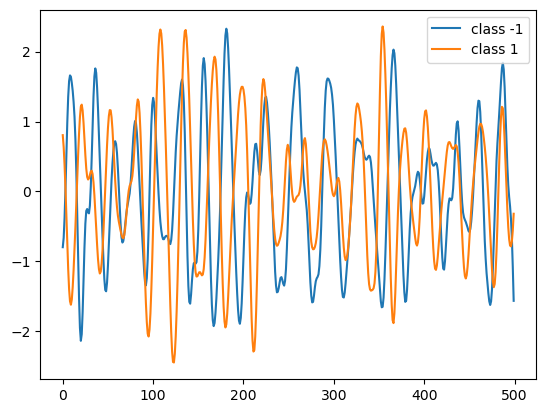

In [17]:
#visualize one example
#unique classes (i.e. unique labels)
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

#plot each class with diff color
plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[0], label="class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()

In [20]:
#basically expand dims in order to use multivariate time series techniques
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

num_classes = len(np.unique(y_train))

#shuffle data
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

#make expected labels [0,1]
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

In [23]:
def make_model(input_shape):
    #using functional model API instead of Sequential
    input_layer = keras.layers.Input(input_shape)
    
    #1d convolution better for time series
    conv1 = keras.layers.Conv1D(filters = 64, kernel_size = 3, padding = "same")(input_layer)
    #normalize
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    #average pooling 
    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    #fully connected w/ softmax 
    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])

In [24]:
epochs = 500
batch_size = 32

#do things during training
callbacks = [
    #save best weights every once in a while
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    #reduce learning rate if learning plateaus
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    #stop early if metric doesn't improve enough
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    #split into validation
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
90/90 [==============================] - 5s 43ms/step - loss: 0.5477 - sparse_categorical_accuracy: 0.7097 - val_loss: 0.7798 - val_sparse_categorical_accuracy: 0.4896 - lr: 0.0010
Epoch 2/500
90/90 [==============================] - 3s 32ms/step - loss: 0.4616 - sparse_categorical_accuracy: 0.7708 - val_loss: 0.8604 - val_sparse_categorical_accuracy: 0.4896 - lr: 0.0010
Epoch 3/500
90/90 [==============================] - 4s 47ms/step - loss: 0.4391 - sparse_categorical_accuracy: 0.7781 - val_loss: 0.7621 - val_sparse_categorical_accuracy: 0.4910 - lr: 0.0010
Epoch 4/500
90/90 [==============================] - 3s 35ms/step - loss: 0.4230 - sparse_categorical_accuracy: 0.7931 - val_loss: 0.6427 - val_sparse_categorical_accuracy: 0.6408 - lr: 0.0010
Epoch 5/500
90/90 [==============================] - 3s 32ms/step - loss: 0.4156 - sparse_categorical_accuracy: 0.7979 - val_loss: 0.5740 - val_sparse_categorical_accuracy: 0.7434 - lr: 0.0010
Epoch 6/500
90/90 [================

90/90 [==============================] - 4s 39ms/step - loss: 0.2480 - sparse_categorical_accuracy: 0.9052 - val_loss: 0.2686 - val_sparse_categorical_accuracy: 0.8793 - lr: 0.0010
Epoch 44/500
90/90 [==============================] - 3s 33ms/step - loss: 0.2342 - sparse_categorical_accuracy: 0.9059 - val_loss: 0.2567 - val_sparse_categorical_accuracy: 0.8988 - lr: 0.0010
Epoch 45/500
90/90 [==============================] - 3s 32ms/step - loss: 0.2388 - sparse_categorical_accuracy: 0.9038 - val_loss: 0.4899 - val_sparse_categorical_accuracy: 0.7545 - lr: 0.0010
Epoch 46/500
90/90 [==============================] - 3s 32ms/step - loss: 0.2407 - sparse_categorical_accuracy: 0.8972 - val_loss: 0.9488 - val_sparse_categorical_accuracy: 0.6269 - lr: 0.0010
Epoch 47/500
90/90 [==============================] - 3s 31ms/step - loss: 0.2411 - sparse_categorical_accuracy: 0.9010 - val_loss: 0.2921 - val_sparse_categorical_accuracy: 0.8544 - lr: 0.0010
Epoch 48/500
90/90 [=======================

90/90 [==============================] - 3s 31ms/step - loss: 0.1113 - sparse_categorical_accuracy: 0.9642 - val_loss: 0.2454 - val_sparse_categorical_accuracy: 0.8960 - lr: 0.0010
Epoch 86/500
90/90 [==============================] - 4s 39ms/step - loss: 0.1062 - sparse_categorical_accuracy: 0.9646 - val_loss: 0.1364 - val_sparse_categorical_accuracy: 0.9612 - lr: 0.0010
Epoch 87/500
90/90 [==============================] - 3s 32ms/step - loss: 0.1138 - sparse_categorical_accuracy: 0.9580 - val_loss: 0.1544 - val_sparse_categorical_accuracy: 0.9348 - lr: 0.0010
Epoch 88/500
90/90 [==============================] - 3s 32ms/step - loss: 0.1090 - sparse_categorical_accuracy: 0.9639 - val_loss: 0.2617 - val_sparse_categorical_accuracy: 0.8877 - lr: 0.0010
Epoch 89/500
90/90 [==============================] - 3s 32ms/step - loss: 0.1163 - sparse_categorical_accuracy: 0.9622 - val_loss: 0.1181 - val_sparse_categorical_accuracy: 0.9639 - lr: 0.0010
Epoch 90/500
90/90 [=======================

Epoch 127/500
90/90 [==============================] - 2s 26ms/step - loss: 0.0808 - sparse_categorical_accuracy: 0.9712 - val_loss: 0.0819 - val_sparse_categorical_accuracy: 0.9653 - lr: 5.0000e-04
Epoch 128/500
90/90 [==============================] - 2s 26ms/step - loss: 0.0786 - sparse_categorical_accuracy: 0.9688 - val_loss: 0.0784 - val_sparse_categorical_accuracy: 0.9736 - lr: 5.0000e-04
Epoch 129/500
90/90 [==============================] - 2s 26ms/step - loss: 0.0787 - sparse_categorical_accuracy: 0.9753 - val_loss: 0.1332 - val_sparse_categorical_accuracy: 0.9431 - lr: 5.0000e-04
Epoch 130/500
90/90 [==============================] - 2s 26ms/step - loss: 0.0819 - sparse_categorical_accuracy: 0.9698 - val_loss: 0.1162 - val_sparse_categorical_accuracy: 0.9528 - lr: 5.0000e-04
Epoch 131/500
90/90 [==============================] - 2s 27ms/step - loss: 0.0791 - sparse_categorical_accuracy: 0.9750 - val_loss: 0.0761 - val_sparse_categorical_accuracy: 0.9695 - lr: 5.0000e-04
Epoch

90/90 [==============================] - 2s 25ms/step - loss: 0.0622 - sparse_categorical_accuracy: 0.9812 - val_loss: 0.0754 - val_sparse_categorical_accuracy: 0.9709 - lr: 2.5000e-04
Epoch 169/500
90/90 [==============================] - 2s 26ms/step - loss: 0.0679 - sparse_categorical_accuracy: 0.9764 - val_loss: 0.0698 - val_sparse_categorical_accuracy: 0.9764 - lr: 2.5000e-04
Epoch 170/500
90/90 [==============================] - 2s 26ms/step - loss: 0.0613 - sparse_categorical_accuracy: 0.9774 - val_loss: 0.0726 - val_sparse_categorical_accuracy: 0.9764 - lr: 2.5000e-04
Epoch 171/500
90/90 [==============================] - 2s 25ms/step - loss: 0.0654 - sparse_categorical_accuracy: 0.9788 - val_loss: 0.0698 - val_sparse_categorical_accuracy: 0.9764 - lr: 2.5000e-04
Epoch 172/500
90/90 [==============================] - 2s 25ms/step - loss: 0.0668 - sparse_categorical_accuracy: 0.9767 - val_loss: 0.0706 - val_sparse_categorical_accuracy: 0.9736 - lr: 2.5000e-04
Epoch 173/500
90/90

90/90 [==============================] - 2s 27ms/step - loss: 0.0598 - sparse_categorical_accuracy: 0.9788 - val_loss: 0.0726 - val_sparse_categorical_accuracy: 0.9709 - lr: 1.2500e-04
Epoch 210/500
90/90 [==============================] - 3s 32ms/step - loss: 0.0626 - sparse_categorical_accuracy: 0.9781 - val_loss: 0.0612 - val_sparse_categorical_accuracy: 0.9806 - lr: 1.2500e-04
Epoch 211/500
90/90 [==============================] - 3s 31ms/step - loss: 0.0593 - sparse_categorical_accuracy: 0.9788 - val_loss: 0.0622 - val_sparse_categorical_accuracy: 0.9806 - lr: 1.2500e-04
Epoch 212/500
90/90 [==============================] - 3s 36ms/step - loss: 0.0565 - sparse_categorical_accuracy: 0.9826 - val_loss: 0.0623 - val_sparse_categorical_accuracy: 0.9778 - lr: 1.2500e-04
Epoch 213/500
90/90 [==============================] - 3s 29ms/step - loss: 0.0603 - sparse_categorical_accuracy: 0.9816 - val_loss: 0.0657 - val_sparse_categorical_accuracy: 0.9736 - lr: 1.2500e-04
Epoch 214/500
90/90

90/90 [==============================] - 2s 27ms/step - loss: 0.0549 - sparse_categorical_accuracy: 0.9837 - val_loss: 0.0656 - val_sparse_categorical_accuracy: 0.9750 - lr: 1.0000e-04
Epoch 251/500
90/90 [==============================] - 2s 26ms/step - loss: 0.0540 - sparse_categorical_accuracy: 0.9830 - val_loss: 0.0591 - val_sparse_categorical_accuracy: 0.9792 - lr: 1.0000e-04
Epoch 252/500
90/90 [==============================] - 2s 27ms/step - loss: 0.0539 - sparse_categorical_accuracy: 0.9833 - val_loss: 0.0732 - val_sparse_categorical_accuracy: 0.9681 - lr: 1.0000e-04
Epoch 253/500
90/90 [==============================] - 2s 27ms/step - loss: 0.0576 - sparse_categorical_accuracy: 0.9816 - val_loss: 0.0771 - val_sparse_categorical_accuracy: 0.9667 - lr: 1.0000e-04
Epoch 254/500
90/90 [==============================] - 2s 26ms/step - loss: 0.0526 - sparse_categorical_accuracy: 0.9840 - val_loss: 0.0624 - val_sparse_categorical_accuracy: 0.9764 - lr: 1.0000e-04
Epoch 255/500
90/90

90/90 [==============================] - 2s 26ms/step - loss: 0.0523 - sparse_categorical_accuracy: 0.9833 - val_loss: 0.0613 - val_sparse_categorical_accuracy: 0.9764 - lr: 1.0000e-04
Epoch 292/500
90/90 [==============================] - 3s 28ms/step - loss: 0.0515 - sparse_categorical_accuracy: 0.9837 - val_loss: 0.0659 - val_sparse_categorical_accuracy: 0.9709 - lr: 1.0000e-04
Epoch 293/500
90/90 [==============================] - 2s 26ms/step - loss: 0.0510 - sparse_categorical_accuracy: 0.9833 - val_loss: 0.0702 - val_sparse_categorical_accuracy: 0.9695 - lr: 1.0000e-04
Epoch 294/500
90/90 [==============================] - 2s 26ms/step - loss: 0.0559 - sparse_categorical_accuracy: 0.9792 - val_loss: 0.0588 - val_sparse_categorical_accuracy: 0.9778 - lr: 1.0000e-04
Epoch 295/500
90/90 [==============================] - 2s 27ms/step - loss: 0.0561 - sparse_categorical_accuracy: 0.9823 - val_loss: 0.0633 - val_sparse_categorical_accuracy: 0.9778 - lr: 1.0000e-04
Epoch 296/500
90/90

In [25]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

42/42 [==============================] - 0s 7ms/step - loss: 0.0919 - sparse_categorical_accuracy: 0.9674
Test accuracy 0.967424213886261
Test loss 0.09185503423213959


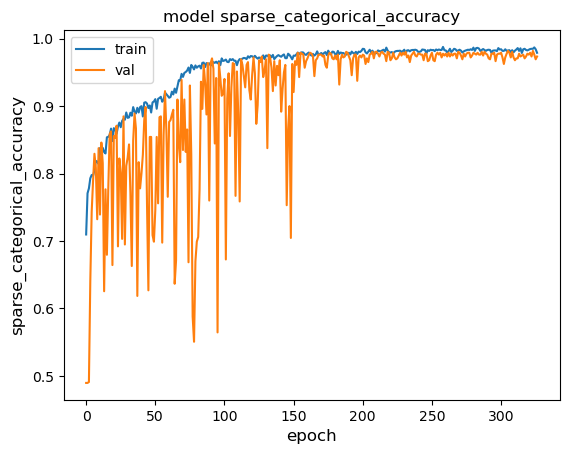

In [26]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()